In [1]:
import qiskit
from qiskit import *
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from math import pi
from qiskit_aer import AerSimulator


In [2]:
def execute(qc, backend, shots=1024):
    compiled = transpile(qc, backend)
    job = backend.run(compiled, shots=shots)
    return job


In [3]:
# Creating registers with n qubits
n =7  # for a local backend n can go as up as 23, after that it raises a Memory Error
qr = QuantumRegister(n, name='qr')
cr = ClassicalRegister(n, name='cr')

qc = QuantumCircuit(qr, cr, name='QC')

In [4]:
# Generate a random number in the range of available qubits [0,65536))
alice_key = np.random.randint(0,2**n)#here we can replace by a key from a quantum key generator
alice_key = np.binary_repr(alice_key,n)

In [5]:
print(alice_key)

1110011


In [6]:
for i in range(len(alice_key)):
 if alice_key[i]=='1':
    qc.x(qr[i])

Alice Basis ['H', 'S', 'S', 'H', 'H', 'H', 'H']


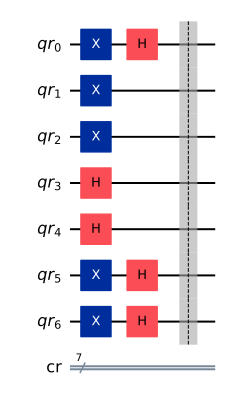

In [7]:
B=[]
for i in range(len(alice_key)):

 if 0.5 < np.random.random():
    qc.h(qr[i])
    B.append("H")
 else:
    B.append("S")
    pass
    
qc.barrier()  
print("Alice Basis",B)
%config InlineBackend.figure_format = 'svg'
qc.draw(output='mpl')

Bob Basis ['H', 'H', 'H', 'H', 'H', 'H', 'S']


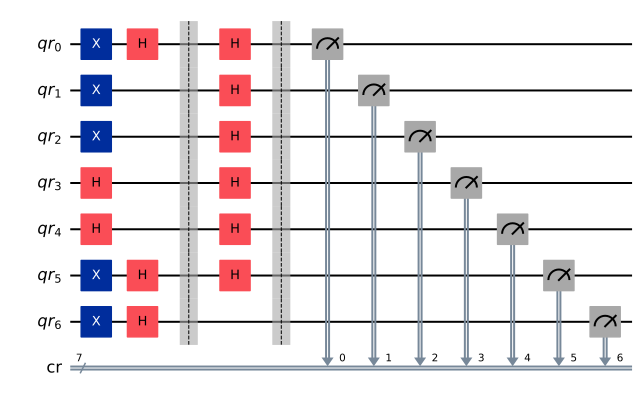

In [8]:
C=[]
for i in range(len(alice_key)):
 if 0.5 < np.random.random():
    qc.h(qr[i])
    C.append("H")
    
 else:
    C.append("S")
qc.barrier()
for i in range(len(alice_key)):
 qc.measure(qr[i],cr[i])
print("Bob Basis",C)
qc.draw(output='mpl')

In [9]:
simulator = AerSimulator()
result = execute(qc, backend = simulator).result()
print("Bob key :",list(result.get_counts(qc))[0])
print("Bob Basis",C)

print("Alice key :",alice_key)
print("Alice Basis :",B)

Bob key : 1100011
Bob Basis ['H', 'H', 'H', 'H', 'H', 'H', 'S']
Alice key : 1110011
Alice Basis : ['H', 'S', 'S', 'H', 'H', 'H', 'H']


In [10]:
def sifted_key(A_basis,B_basis,key): 
 correct_basis=[]
 sifted_key=''

 for i in range(len(A_basis)):
  if A_basis[i]==B_basis[i]:
    correct_basis.append(i)
    sifted_key+=key[i]
  else:
    pass 
 return sifted_key,correct_basis
a=sifted_key(B,C,alice_key)
print("sifted key",a[0])
print("Basis",a[1])

sifted key 1001
Basis [0, 3, 4, 5]


In [11]:
BB84_key=a[0]

In [12]:
from qiskit import QuantumCircuit

def wordToBV(word, n=7):
    """
    Convert a string to a list of Bernstein-Vazirani circuits,
    each hiding the ASCII binary of one character in the word.
    
    Parameters:
    - word (str): The input text string.
    - n (int): Number of bits (default: 7 for ASCII-7).
    
    Returns:
    - List of QuantumCircuits, one per character.
    """
    # Convert each character to 7-bit binary
    binary_list = [bin(ord(ch))[2:].zfill(n) for ch in word]
    print("Binary strings:", binary_list)
    
    circuit_list = []

    for bitstring in binary_list:
        # Create a Bernstein-Vazirani circuit with n qubits + 1 ancilla
        qc = QuantumCircuit(n + 1, n)

        # Step 1: Put ancilla in |–⟩ state
        qc.h(n)
        qc.z(n)

        # Step 2: Hadamard on input qubits
        qc.h(range(n))

        qc.barrier()

        # Step 3: Oracle U_f: flip ancilla for each bit i where s_i = 1
        # Reverse bitstring due to Qiskit's little-endian qubit order
        bitstring = bitstring[::-1]
        for i in range(n):
            if bitstring[i] == '1':
                qc.cx(i, n)
            else:
                qc.id(i)  # Identity — does nothing

        qc.barrier()

        # Step 4: Final Hadamard gates
        qc.h(range(n))

        # Step 5: Measure input qubits
        qc.measure(range(n), range(n))

        circuit_list.append(qc)

    return circuit_list


Binary strings: ['1100010', '1101110', '1101101', '1101001', '1110100']


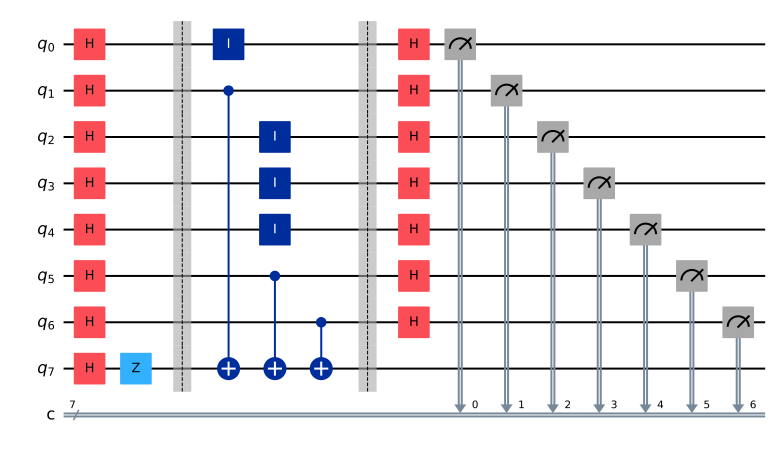

In [13]:
circuit_to_run = wordToBV('bnmit')#Secret Msg
circuit_to_run[0].draw(output='mpl')

In [14]:
backend = simulator
shots = 1000
results = execute(circuit_to_run[::-1], backend=backend, shots=shots).result()
answer = results.get_counts()

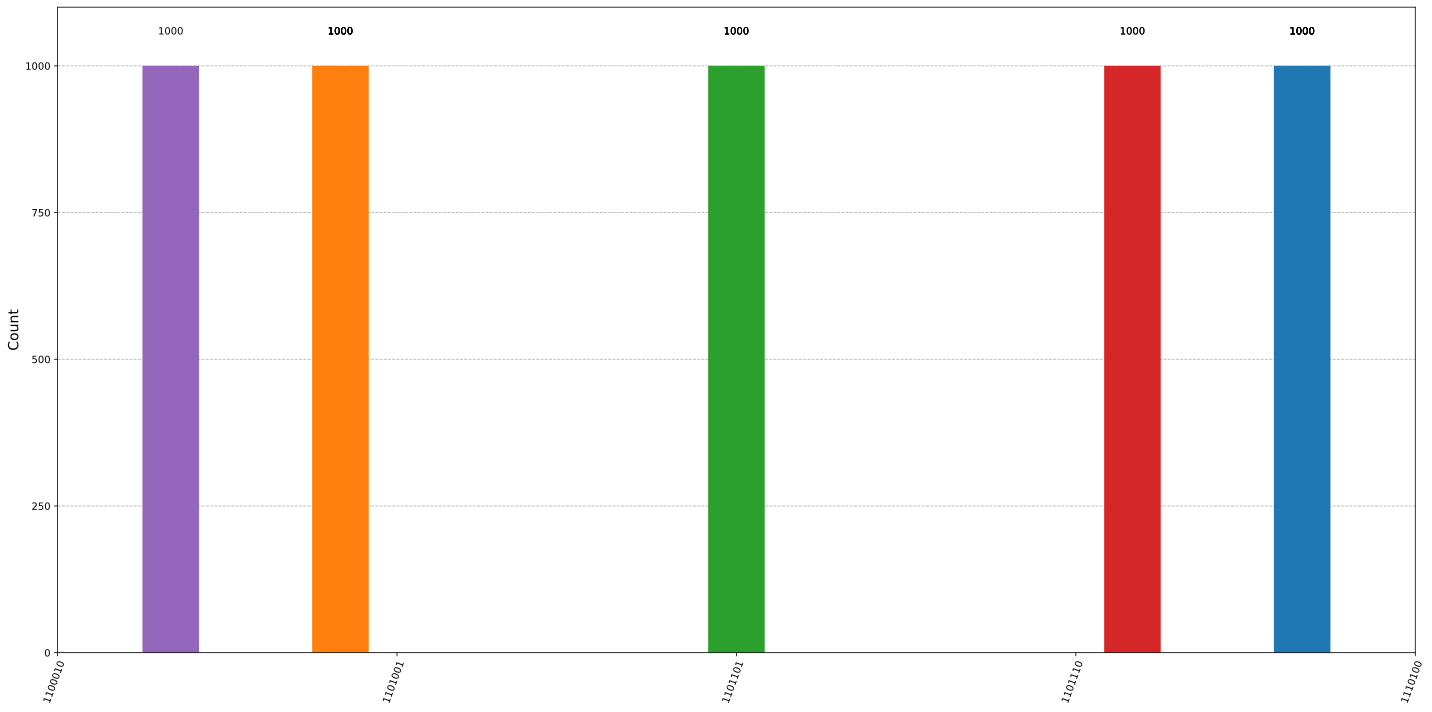

In [15]:
plot_histogram(answer,figsize=(20,10),)

In [16]:
def encrypt(BB84_key, letter):
    """Calculates XOR"""
    b = int(BB84_key, 2)
    x = sum([ord(i) for i in letter])
    return format(b ^ x, "b")


def stega_encoder(LM, carrier_msg):
    """Encodes LM bits message into carrier_msg"""
    message = ""
    size = len(LM[0])
    i = 0
    for j, bitstring in enumerate(LM):
        for k, digit in enumerate(bitstring):
            while (not carrier_msg[i].isalpha()):
                message += carrier_msg[i]
                i += 1

            if digit == "1":
                letter = carrier_msg[i].upper()
                message += letter
            else:
                message += carrier_msg[i]

            i += 1
    
    if i < len(carrier_msg):
        message += carrier_msg[i:]

    return message


def stega_decoder(new_carrier_msg, BB84_key):
    """Decodes secret message from new_carrier_msg"""

    b = int(BB84_key, 2)

    message = ""
    bitstring = ""
    for char in new_carrier_msg:
        if char.isalpha():
            if char.isupper():
                bitstring += "1"
            else:
                bitstring += "0"

        if len(bitstring) == 7:
            x = int(bitstring, 2)
            message += chr(b ^ x)
            bitstring = ""

    return message

In [17]:
for i in range(100, 1100):
    carrier_msg=chr(i)

In [18]:
str(carrier_msg)

'ы'

In [19]:
encrypt(BB84_key,'bnmit')

'1000010011'

In [20]:
secret_msg='bnmit'
L=[]
for c in secret_msg:
    L.append(encrypt(BB84_key,c))
print(L)

['1101011', '1100111', '1100100', '1100000', '1111101']


In [21]:
carrier_msg='Bangalore is known as silicon city of india'

In [22]:
new_carrier_msg=stega_encoder(L, carrier_msg)
print(new_carrier_msg)

BAnGaLORE is KNOWN as SilICon citY OF INdIa


In [23]:
stega_decoder(new_carrier_msg, BB84_key)

'bnmit'